# Analyzing the influence of the "FUN bug" on the CLM5-PPE
- Updated Oct 6, 2023
- Daniel Kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
import seaborn as sns

## spin up some extra cores on CASPER

In [115]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='00:15:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(15)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46391 instead
  warnings.warn(


In [3]:
from utils import *

### FUNbug in the OAAT

In [4]:
la=xr.open_dataset('sparsegrid_landarea.nc').landarea

In [19]:
dvs=['GPP','AR','HR','NBP','NPP_NUPTAKE','TLAI','TOTVEGC','TOTSOMC','EFLX_LH_TOT','SNOWDP','SOILWATER_10CM']

In [10]:
#reading in the corrected dataset
d='/glade/campaign/cgd/tss/projects/PPE/PPEn11_OAAT/CTL2010/hist/'
files=sorted(glob.glob(d+'*FUN*h0*'))
files=[files[0],*files]
files=[list(f) for f in np.array(files).reshape([8,2])]
ds=get_ds(files,['param','minmax'],dvs=dvs)
df=pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/funbug.txt')
params={row.key:row.param for i,row in df.iterrows()}
ks=[[f.split('_')[-1].split('.')[0] for f in fs] for fs in files]
ps=[[params[k] for k in kk] for kk in ks]
ds['param']=xr.DataArray(np.array([np.unique(p) for p in ps]).ravel(),dims='param')
ds['minmax']=['min','max']

In [108]:
#reading in the buggy dataset
df=pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/oaat.csv')
files=[]
for p in ds.param.values:
    fs=[]
    for m in ['min','max']:
        if p=='default':m='default'
        ix=(df.param==p)&(df.minmax==m)
        k=df.key[ix].values[0]
        fs.append(glob.glob(d+'*'+k+'*h0*')[0])
    files.append(fs)
ds0=get_ds(files,['param','minmax'],dvs=dvs)
ds0['param']=ds.param
ds0['minmax']=ds.minmax

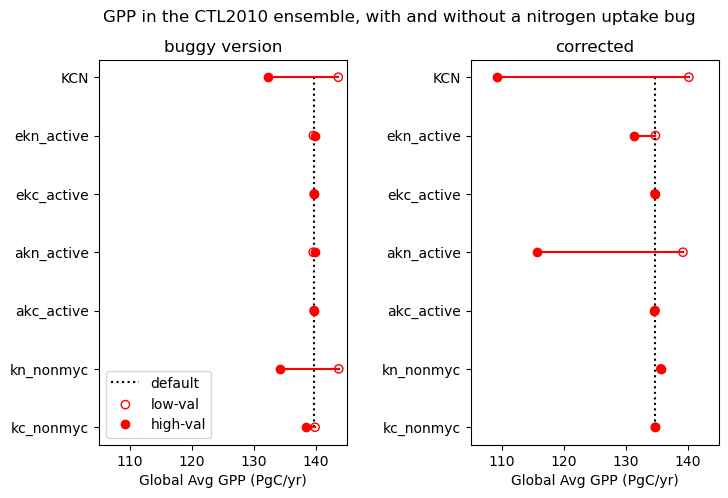

In [109]:
#calculate parameter effect and plot
cf=1e-9*24*60*60*365*la.sum()
da=cf*gmean(amean(ds.GPP),la).mean(dim='year')
da0=cf*gmean(amean(ds0.GPP),la).mean(dim='year')

fig,axs=plt.subplots(1,2,figsize=[8,5])
rank_plot(da0,7,ax=axs[0],sortby='none')
axs[0].set_xlim([105,145])
axs[0].legend(loc=3)
rank_plot(da,7,ax=axs[1],sortby='none')
axs[1].set_xlim([105,145])


ts=['buggy version','corrected']
for ax,t in zip(axs,ts):
    ax.set_xlabel('Global Avg GPP (PgC/yr)')
    ax.set_title(t)

plt.subplots_adjust(wspace=0.5)
fig.suptitle('GPP in the CTL2010 ensemble, with and without a nitrogen uptake bug');
plt.savefig('../figs/supp/funbug.png',dpi=300,bbox_inches='tight')

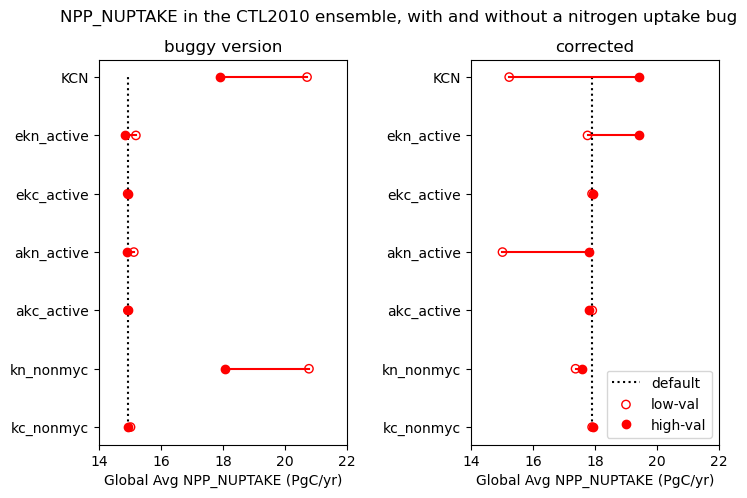

In [122]:
#calculate parameter effect and plot
cf=1e-9*24*60*60*365*la.sum()
v='NPP_NUPTAKE'
da=cf*gmean(amean(ds[v]),la).mean(dim='year')
da0=cf*gmean(amean(ds0[v]),la).mean(dim='year')

fig,axs=plt.subplots(1,2,figsize=[8,5])
rank_plot(da0,7,ax=axs[0],sortby='none')


rank_plot(da,7,ax=axs[1],sortby='none')

axs[1].legend(loc=4)

ts=['buggy version','corrected']
for ax,t in zip(axs,ts):
    ax.set_xlabel('Global Avg '+v+' (PgC/yr)')
    ax.set_xlim([14,22])
    ax.set_title(t)

plt.subplots_adjust(wspace=0.5)
fig.suptitle(v+' in the CTL2010 ensemble, with and without a nitrogen uptake bug');
plt.savefig('../figs/extra/nppnup_funbug.png',dpi=300,bbox_inches='tight')

### FUNbug in the LHC

In [19]:
dvs=['GPP','AR','HR','NBP','NPP_NUPTAKE','TLAI','TOTVEGC','TOTSOMC','EFLX_LH_TOT','SNOWDP','SOILWATER_10CM']

In [39]:
files=['/glade/scratch/linnia/archive/PPEn11_transient_FUNbug0001/lnd/hist/PPEn11_transient_FUNbug0001.clm2.h0.2010-02-01-00000.nc',
       '/glade/scratch/djk2120/PPEn11_transient_LHC0000/run/PPEn11_transient_LHC0000.clm2.h0.2010-02-01-00000.nc']

In [40]:
dvs=['GPP','AR','HR','TLAI','TOTVEGC','TOTSOMC','EFLX_LH_TOT','SNOWDP','SOILWATER_10CM']
ds=get_ds(files,['ens'],dvs=dvs)

In [48]:
for v in dvs:
    x=gmean(amean(ds[v]),la).mean(dim='year')
    dx=x[0]/x[1]
    p=''
    if dx>1:p='+'
    print(v,p+str(np.round(100*dx.values-100,1))+'%')

GPP -5.0%
AR -2.3%
HR -9.7%
TLAI -6.5%
TOTVEGC -2.4%
TOTSOMC -5.1%
EFLX_LH_TOT -1.5%
SNOWDP +0.0%
SOILWATER_10CM +0.5%
